### IMPORTS AND SETUP ###

In [16]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import time

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

batch_size = 64
NOISE_DIM = 100
noise_size = NOISE_DIM
image_size = 64 # image size must be divisible by 4
normalize = False

#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
#     ndf = 32 # good for 32
#     ndf = 40 # good for 64? or 45
#modify
    ndf = 40
    s = int((image_size/4) - 3)

    return nn.Sequential(
        ########################### 
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 3, image_size, image_size),
        nn.Conv2d(3, ndf, 4, stride=2, padding=1), #halves the size (now 16)
        nn.BatchNorm2d(ndf),
        nn.LeakyReLU(0.1, inplace=True),
#         nn.PReLU(1, 0.02),
        nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1), #halves the size (now 8)
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.1, inplace=True),
#         nn.PReLU(1, 0.02),
        nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1), #halves the size (now 4)
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.1, inplace=True),
#         nn.PReLU(1, 0.02),
        nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1), #halves the size (now 2)
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.1, inplace=True),
#         nn.PReLU(1, 0.02),

        nn.Conv2d(ndf*8, 1, 4, stride=2, padding=0), #64 alt
        nn.Tanh(),
#         nn.Sigmoid(),
        Flatten()
    )

def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    s = int(image_size/4)
#     ngf = 64 # good for 32
#     ngf = 100 #good for 64?
#modify
    ngf = 100
    

    return nn.Sequential( # update
        # start is batch x noise_dim x 1 x 1
#         nn.ConvTranspose2d(noise_dim, ngf*16, 4, stride=2, padding=1), #64
#         nn.ConvTranspose2d(noise_dim, ngf*16, 4, stride=4, padding=0), #128
        nn.ConvTranspose2d(noise_dim, ngf*8, 4, stride=4, padding=0), #64 alt

        nn.ReLU(inplace=True),
#         nn.BatchNorm2d(ngf*16),
        
        
#         nn.ConvTranspose2d(ngf*16, ngf*8, 4, stride=2, padding=1),
#         nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*8),
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*4),
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf*2),
        nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(ngf),     
        nn.ConvTranspose2d(ngf, 3, 4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
#     rand = torch.rand([batch_size, dim]) * 2 - 1
    rand = torch.rand([batch_size, dim, 1, 1]) * 2 - 1
    return rand
#     return torch.rand([batch_size, 1, image_size, image_size]) * 2 - 1

def sample_noise_square(batch_size, dim):
    rand = torch.rand([batch_size, dim, dim]) * 2 - 1
    return rand

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999)) #5e-4 good for 32
    return optimizer


### GENERATE ###

C:\Users\ngs\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


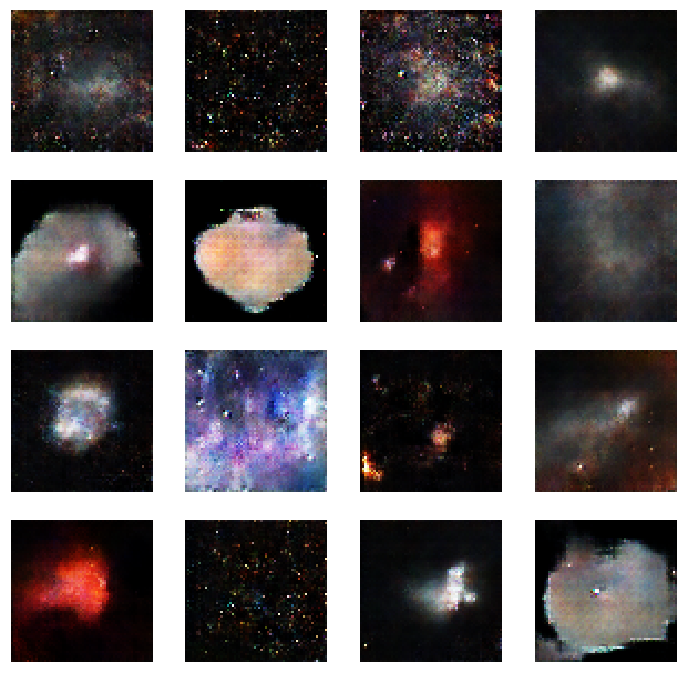

In [17]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

G_ac = G_DC
G_ac.load_state_dict(torch.load('best-model.pt'))

g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
fake_images = G_ac(g_fake_seed)
fake_images = fake_images.resize(batch_size, 3, image_size, image_size).type(dtype) / 2 + 0.5
    
imgs_numpy = fake_images.data.cpu().numpy()
images = imgs_numpy[0:16] #shape is 1 x 3*image_size*image_size


images.resize(images.shape[0], 3, image_size, image_size)
images = torch.from_numpy(images)
images = images.permute(0, 2, 3, 1) # becomes N x H x W x C
images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

fig = plt.figure(figsize=(3 * sqrtn, 3 * sqrtn))
gs = gridspec.GridSpec(sqrtn, sqrtn)
gs.update(wspace=0.2, hspace=0.2)

for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([image_size, image_size, 3]), vmin=0,vmax=255)


plt.show()